# 模型训练

1. 读取数据集，读取完之后保存成`.npy`文件，然后调用`train_test_split`进行训练集和验证集的切分
2. 搭建CNN-LSTM网络，添加过拟合处理，进行模型训练，保存训练好的模型
3. 训练结果可视化

In [6]:
import cv2
from keras.layers.core import *
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import os

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False # 设置支持负号显示

In [7]:
# =======================================  读取数据集 ===================================

name = os.listdir('mnist+/mnist+')
classesnum = len(name)  

X = []  # 保存数据
Y = []  # 保存标签

for i in range(len(name)):
    path = 'mnist+/mnist+/' + name[i]  # 文件夹路径
    sub_name = os.listdir(path)        
    for j in range(len(sub_name)):
        sub_path = path + '/' + sub_name[j]  # 拼接每个图像的路径
        data = cv2.imread(sub_path,0)       # 读入图像
        
        X.append(data/255)  # 归一化后存入列表
        Y.append(i)         # 添加标签

# 保存为npy文件
np.save('x.npy', X)  
np.save('y.npy', Y)  

X_path = 'x.npy'  
Y_path = 'y.npy'  


X = np.load(X_path)  
Y = np.load(Y_path)  
print(X.shape, Y.shape)

Y = to_categorical(Y,classesnum)    # 转为one-hot编码
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=42,stratify=Y)  # 训练集和验证集切割

print(x_train.shape,x_test.shape)

(93895, 28, 28) (93895,)
(65726, 28, 28) (28169, 28, 28)


In [10]:
# # 打印验证集和标签
# for i in range(x_test.shape[0]):
#     print("验证集样本:", i)
#     # print("图像数据:", x_test[i])
#     print("标签:", np.argmax(y_test[i]))
#     print()

# 创建一个文本文件
with open('validation_set.txt', 'w') as file:
    # 逐个写入验证集和标签
    for i in range(x_test.shape[0]):
        file.write("验证集样本: {}\n".format(i))
        # file.write("图像数据:\n")
        # file.write(str(x_test[i]))
        file.write("\n")
        file.write("标签: {}\n".format(np.argmax(y_test[i])))
        file.write("\n")


In [3]:
from keras.models import Model
from keras.layers import Input, Conv1D, LSTM, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l2

# cnn-lstm网络，增加了过拟合处理和提前终止训练的回调函数
def cnn_lstm():
    inputs = Input(shape=(28, 28))
    x = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = LSTM(64, return_sequences=True, activation='relu')(x)
    x = LSTM(64, return_sequences=True, activation='relu')(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)  # 增加L2正则化
    x = Dropout(0.5)(x)  # 增加dropout层
    output = Dense(classesnum, activation='softmax')(x)  
    model = Model(inputs=inputs, outputs=output)
    return model

m = cnn_lstm()

optimizer = Adam()  # Adam优化器
m.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

filepath = "cnn-lstm3.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)  # 回调函数，如果10个epoch变化不大就别训练了
history = m.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=1000, callbacks=[checkpoint, early_stopping])


Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 2.0162 - acc: 0.4663
Epoch 1: val_acc improved from -inf to 0.77880, saving model to cnn-lstm3.h5
66/66 [==============================] - 19s 265ms/step - loss: 2.0162 - acc: 0.4663 - val_loss: 0.9046 - val_acc: 0.7788
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.6597 - acc: 0.8460
Epoch 2: val_acc improved from 0.77880 to 0.91338, saving model to cnn-lstm3.h5
66/66 [==============================] - 17s 264ms/step - loss: 0.6597 - acc: 0.8460 - val_loss: 0.4257 - val_acc: 0.9134
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.4202 - acc: 0.9128
Epoch 3: val_acc improved from 0.91338 to 0.93990, saving model to cnn-lstm3.h5
66/66 [==============================] - 17s 264ms/step - loss: 0.4202 - acc: 0.9128 - val_loss: 0.3158 - val_acc: 0.9399
Epoch 4/50
66/66 [==============================] - ETA: 0s - loss: 0.3190 - acc: 0.9358
Epoch 4: val_acc improved from 0.93990 to

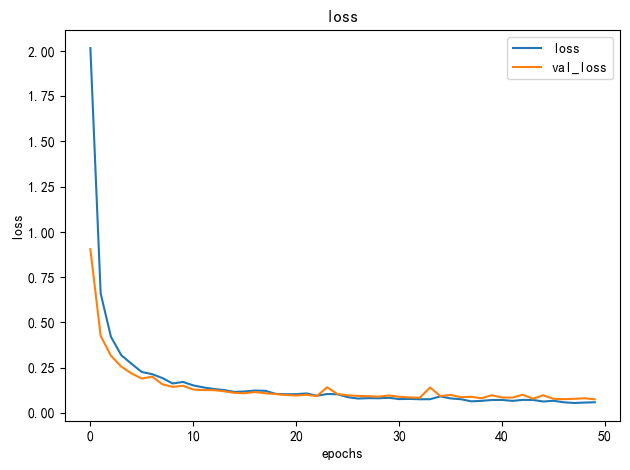

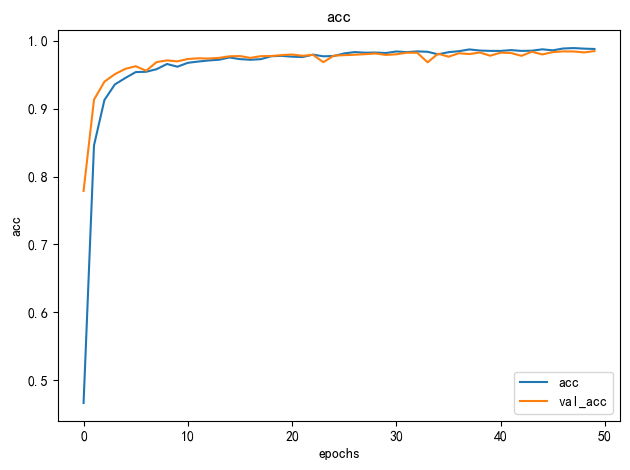

In [5]:
# 绘图
## 绘制损失函数的图像
plt.figure()
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.tight_layout()
plt.legend()
plt.show()

## 训练精度的图像
plt.figure()
plt.plot(history.history['acc'],label='acc')
plt.plot(history.history['val_acc'],label='val_acc')
plt.title('acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.tight_layout()
plt.legend()
plt.show()